# Introduction
This part of the report include the Python implementation of the Machine Learning methods discussed above. Parts of the codes are distributed as materials in CS-C3240 Machine Learning course at Aalto University, and the student project _Stellar classification with logistic regression_. The appendix will cover the codes for preprocessing the dataframe, visualizing the features and data, creating the validation dataset and building the models. Below is the importation of the libraries neccessary for the project.

In [1]:
%config Completer.use_jedi = False  # enable code auto-completion

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error  # evaluation metrics

from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures # function to generate polynomial and interaction features
from sklearn.neural_network import MLPRegressor

# Preprocessing and Visualization of The Dataset
In this part we will first import the dataset containing the NEOs and its features to the code. Preprocessing includes dropping irrelevant features and create a new _average diameter_ feature subtitute for the other two diameter features. The first 5 datapoints of the new dataframe is printed below.

In [2]:
# Read in the data stored in the file 'neo_v2.csv'
# Clean the dataframe and modify into necessary features

df = pd.read_csv('neo_v2.csv')
df.drop(columns=['id','name','relative_velocity','miss_distance','orbiting_body','sentry_object'],inplace=True)  # drop irrelevant columns

df.columns =['minDiameter','maxDiameter','Luminosity','Harzadous'] # rename columns 

# Replace the minimum and maximum size with a new feature: average size
# Drop all datapoints with invalid features
df=df.dropna(axis=0)
data = df.assign(Diameter_avg = (df["minDiameter"] + df["maxDiameter"]) / 2)
data = data.drop(['minDiameter','maxDiameter'],axis=1)
data.head(5)

,Luminosity,Harzadous,Diameter_avg
0,16.73,False,1.938843
1,20.00,True,0.430073
2,17.83,False,1.168268
3,22.20,False,0.156150
4,20.09,True,0.412613


We can justify by visualization that the average diameter is determined correctly as the relationship between minimum and maximum diameter is linear, hence the average is arithmetical. We also have the distribution of NEOs based on their average diameter and intrinsic luminosity below.

Text(0.5, 1.0, 'Distribution of NEOs')

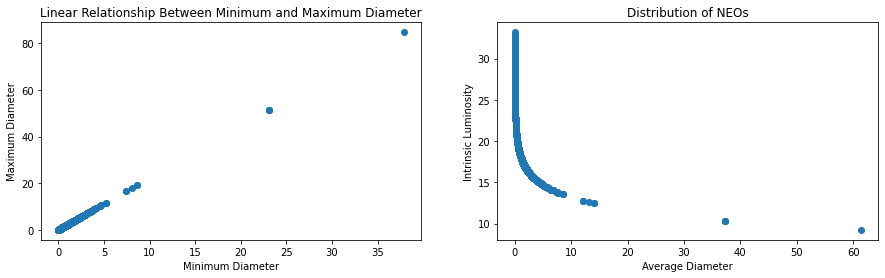

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

axes[0].scatter(df['minDiameter'],df['maxDiameter']);
axes[0].set_xlabel("Minimum Diameter")
axes[0].set_ylabel("Maximum Diameter")
axes[0].set_title("Linear Relationship Between Minimum and Maximum Diameter")

axes[1].scatter(data['Diameter_avg'],data['Luminosity']);
axes[1].set_xlabel("Average Diameter")
axes[1].set_ylabel("Intrinsic Luminosity")
axes[1].set_title("Distribution of NEOs")

Since the dataframe is imbalanced, we create a new dataframe with the ratio of the label approximately 1:1. The next step is to change the Boolean type into integer (True = 1, False = 0) and separate the labels from the feature.

In [4]:
# New dataframe with a 1:1 ratio of the label
df1 = data[data['Harzadous'] == True]
df0 = data[data['Harzadous'] == False].sample(frac=0.10)
frames = [df1, df0]
data = pd.concat(frames)

# Change the label from Boolean to Int (True = 1, False = 0)
y = data['Harzadous'].astype(int)
y = np.array(y)

# Separate the label and the feature
data.drop(columns=['Harzadous'],inplace=True)
X = data.to_numpy().reshape(17040, -1)

From the new dataset we can visualize the distribution of the harzadous NEOs as below.

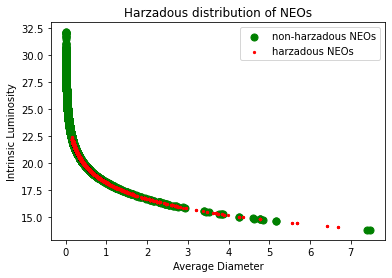

In [5]:
# plot results
fig, ax = plt.subplots()
ax.set_xlabel("Average Diameter")
ax.set_ylabel("Intrinsic Luminosity")
ax.set_title("Harzadous distribution of NEOs")
ax.scatter(df0['Diameter_avg'],df0['Luminosity'],s=50,c="green",label="non-harzadous NEOs") 
ax.scatter(df1['Diameter_avg'],df1['Luminosity'],s=5,c="r",label="harzadous NEOs")
ax.legend()
plt.show()

## Determination of the Validation Method
In this project, we determine the training and validation set by using k-fold Cross-validation. In regard of the size of the data and running time, _k = 5_ is a reasonable choice with a seed of _seed = 4_.

In [6]:
#define k-fold
k = 5
shuffle = True
seed = 4
kfold = KFold(n_splits=k, shuffle=shuffle, random_state=seed)

# Implementation of the Machine Learning Methods
## Linear Regression and Polynomial Logistic Regression model
First we consider a classic _Linear Regression model_: the model is built using the training sets, and the accuracy of the validation sets are recorded. We create arrays to record the training and validation errors at each fold, and the mean error and mean accuracy is reported at the end of the model.

In [7]:
tr_errors1 = [] #k different errors
val_errors1 = []
average_val_accuracy1 = 0

#go though all folds
for (train_index, val_index) in kfold.split(X):
    #split into training and validation sets
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    #Linear Regression model
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    #validation
    y_pred_val = clf.predict(X_val)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    average_val_accuracy1 += accuracy_val
    #calculate the errors
    tr_error = mean_squared_error(y_train, y_pred_train)
    val_error = mean_squared_error(y_val, y_pred_val)
    #save errors
    tr_errors1.append(tr_error)
    val_errors1.append(val_error)
#scores
average_train_error1 = np.mean(tr_errors1)
average_val_error1 = np.mean(val_errors1)
print("Logistic regression model:")
print("Average training error : ", average_train_error1)
print("Average validation error : ", average_val_error1)
print("Average validation accuracy : ", average_val_accuracy1/5)

Logistic regression model:
Average training error :  0.1307511737089202
Average validation error :  0.13075117370892014
Average validation accuracy :  0.8692488262910798


We can fine-tune this method by letting the hypothesis space a polynomials of degree 2 and apply _Polynomial Logistic Regression model_ using polynomial features generator and standard scalar. The mean error and mean accuracy is reported at the end of the model, and we can see that the accuracy is improved by 0.06%.

In [8]:
tr_errors2 = [] #k different errors
val_errors2 = []
average_val_accuracy2 = 0

for (train_index, val_index) in kfold.split(X):
    #split into training and validation sets
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    #Polynomial Logistic Regression model
    log_regr = LogisticRegression()
    poly = PolynomialFeatures(degree=2)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit the raw features
    scaler = preprocessing.StandardScaler().fit(X_train_poly)
    X_train_poly = scaler.transform(X_train_poly) #scale the transformed features
    log_regr.fit(X_train_poly, y_train)    # apply logistics regression to these new features and labels
    y_pred_train = log_regr.predict(X_train_poly)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    #validation
    X_val_poly = poly.fit_transform(X_val)
    scaler = preprocessing.StandardScaler().fit(X_val_poly)
    X_val_poly = scaler.transform(X_val_poly)
    y_pred_val = log_regr.predict(X_val_poly)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    average_val_accuracy2 += accuracy_val
    #calculate the errors
    tr_error = mean_squared_error(y_train, y_pred_train)
    val_error = mean_squared_error(y_val, y_pred_val)
    #save errors
    tr_errors1.append(tr_error)
    val_errors1.append(val_error)
 
    tr_errors2.append(tr_error)
    val_errors2.append(val_error)

average_train_error2 = np.mean(tr_errors2)
average_val_error2 = np.mean(val_errors2)
print("Polynomial logistic regression model:")
print("Average training error : ", average_train_error2)
print("Average validation error : ", average_val_error2)
print("Average validation accuracy : ", average_val_accuracy2/5)

Polynomial logistic regression model:
Average training error :  0.12607100938967136
Average validation error :  0.13022300469483566
Average validation accuracy :  0.8697769953051644


## Multilayer Perceptron (MLP) model
In this method, we apply a _Multilayer Perceptron (MLP) model_ using 5 hidden layers and 15 neurons in each of the layer. The mean error is reported at the end of the model, and the mean accuracy is calculated implicitly from the errors.

In [10]:
tr_errors3 = []
val_errors3 = []

num_layers = 5    # number of hidden layers
num_neurons = 15  # number of neurons in each layer
hidden_layer_sizes = tuple([num_neurons]*num_layers) # size (num of neurons) of each layer stacked in a tuple

for (train_index, val_index) in kfold.split(X):
    #split into training and validation sets
    X_train, y_train, X_val, y_val = X[train_index], y[train_index], X[val_index], y[val_index]
    
    mlp_regr = MLPRegressor(hidden_layer_sizes,max_iter=1000,random_state=42)
    mlp_regr.fit(X_train,y_train)

    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = mean_squared_error(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = mean_squared_error(y_val, y_pred_val) # calculate the validation error
    
    tr_errors3.append(tr_error)
    val_errors3.append(val_error)

average_train_error3 = np.mean(tr_errors3)
average_val_error3 = np.mean(val_errors3)
print("MLP model:")
print("Average training error : ", average_train_error3)
print("Average validation error : ", average_val_error3)
print("Average validation accuracy : ", 1 - average_val_error3)

MLP model:
Average training error :  0.11116010217535119
Average validation error :  0.11113014380886357
Average validation accuracy :  0.8888698561911365


Despite longer runtime, we can see an 2.65% increase in the accuracy in the validation set compared to _Polynomial Logistic Regression model_.